# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

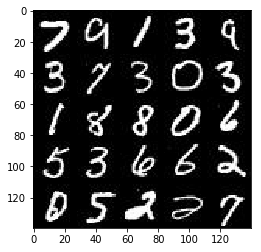

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

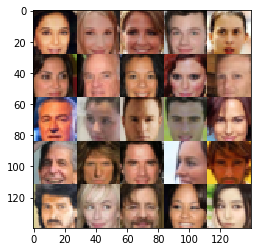

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    print(image_width, image_height, image_channels, z_dim)
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), 'inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

28 28 3 100
Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #I added xavier_initializer & dropout as per reviewer recommendation
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        #return tf.nn.dropout(out,0.75), logits I removed dropout as result is so bad
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #I added dropot as per reviewer recommendation
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid') #to adapt with image width 28
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #print(logits)
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        #return tf.nn.dropout(out,0.5)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # apply smooth as per reviewer recommendation
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print(data_shape)
    print(z_dim)
    data, image_width, image_height, image_channels= data_shape
    
    input_real, input_z, lr = model_inputs(
        image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
     # initalize data
    steps = 0
    print_every=10
    show_every=100
    losses = []
    num_images = 25
   
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2.0
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

    
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, num_images, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
100
28 28 1 100
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 19.3973
Epoch 1/2... Discriminator Loss: 0.8037... Generator Loss: 1.2193
Epoch 1/2... Discriminator Loss: 4.5058... Generator Loss: 21.5009
Epoch 1/2... Discriminator Loss: 0.7895... Generator Loss: 10.6211
Epoch 1/2... Discriminator Loss: 1.7891... Generator Loss: 0.3637
Epoch 1/2... Discriminator Loss: 0.5051... Generator Loss: 3.1902
Epoch 1/2... Discriminator Loss: 0.5857... Generator Loss: 2.9567
Epoch 1/2... Discriminator Loss: 0.6786... Generator Loss: 6.5686
Epoch 1/2... Discriminator Loss: 0.4700... Generator Loss: 2.8975
Epoch 1/2... Discriminator Loss: 0.6225... Generator Loss: 2.4983


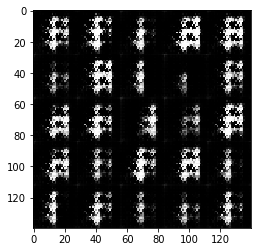

Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 4.6388
Epoch 1/2... Discriminator Loss: 0.7165... Generator Loss: 1.6165
Epoch 1/2... Discriminator Loss: 0.4820... Generator Loss: 4.0855
Epoch 1/2... Discriminator Loss: 0.4886... Generator Loss: 3.1296
Epoch 1/2... Discriminator Loss: 0.4529... Generator Loss: 3.4643
Epoch 1/2... Discriminator Loss: 0.4145... Generator Loss: 3.9261
Epoch 1/2... Discriminator Loss: 0.4488... Generator Loss: 2.5065
Epoch 1/2... Discriminator Loss: 0.5002... Generator Loss: 2.8196
Epoch 1/2... Discriminator Loss: 0.6828... Generator Loss: 2.0514
Epoch 1/2... Discriminator Loss: 0.5807... Generator Loss: 5.1750


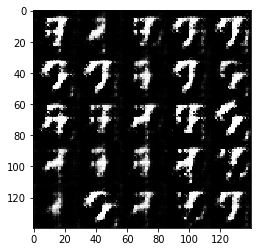

Epoch 1/2... Discriminator Loss: 0.7724... Generator Loss: 5.3052
Epoch 1/2... Discriminator Loss: 0.6585... Generator Loss: 2.3109
Epoch 1/2... Discriminator Loss: 0.6281... Generator Loss: 1.8311
Epoch 1/2... Discriminator Loss: 0.4819... Generator Loss: 3.0293
Epoch 1/2... Discriminator Loss: 1.0039... Generator Loss: 1.3442
Epoch 1/2... Discriminator Loss: 0.5738... Generator Loss: 2.6484
Epoch 1/2... Discriminator Loss: 0.5785... Generator Loss: 2.4979
Epoch 1/2... Discriminator Loss: 0.8983... Generator Loss: 1.4621
Epoch 1/2... Discriminator Loss: 0.6012... Generator Loss: 5.9095
Epoch 1/2... Discriminator Loss: 0.6092... Generator Loss: 2.0636


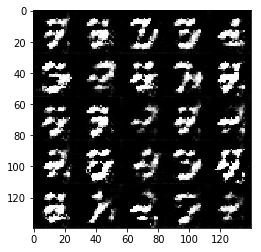

Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 6.1781
Epoch 1/2... Discriminator Loss: 0.9308... Generator Loss: 1.4325
Epoch 1/2... Discriminator Loss: 0.7967... Generator Loss: 3.5104
Epoch 1/2... Discriminator Loss: 0.6622... Generator Loss: 1.8406
Epoch 1/2... Discriminator Loss: 0.7094... Generator Loss: 2.5579
Epoch 1/2... Discriminator Loss: 0.5124... Generator Loss: 2.6510
Epoch 1/2... Discriminator Loss: 0.9254... Generator Loss: 1.1053
Epoch 1/2... Discriminator Loss: 0.5264... Generator Loss: 2.8520
Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 1.1803
Epoch 1/2... Discriminator Loss: 0.7463... Generator Loss: 1.8530


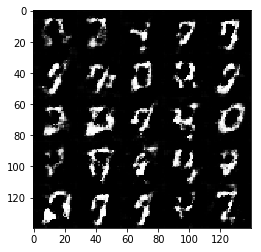

Epoch 1/2... Discriminator Loss: 0.8019... Generator Loss: 1.4639
Epoch 1/2... Discriminator Loss: 0.7035... Generator Loss: 2.1654
Epoch 1/2... Discriminator Loss: 0.7271... Generator Loss: 1.6752
Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 1.3747
Epoch 1/2... Discriminator Loss: 0.9910... Generator Loss: 4.0796
Epoch 1/2... Discriminator Loss: 0.7499... Generator Loss: 1.6687
Epoch 1/2... Discriminator Loss: 0.7054... Generator Loss: 2.2073
Epoch 1/2... Discriminator Loss: 1.0496... Generator Loss: 2.3412
Epoch 1/2... Discriminator Loss: 0.7820... Generator Loss: 2.1031
Epoch 1/2... Discriminator Loss: 1.6353... Generator Loss: 0.4226


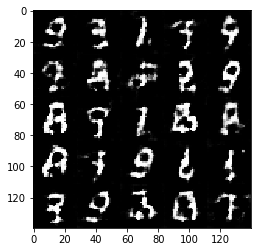

Epoch 1/2... Discriminator Loss: 0.9729... Generator Loss: 1.5467
Epoch 1/2... Discriminator Loss: 0.8115... Generator Loss: 2.5743
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 3.9874
Epoch 1/2... Discriminator Loss: 0.8650... Generator Loss: 1.4314
Epoch 1/2... Discriminator Loss: 0.6989... Generator Loss: 2.0108
Epoch 1/2... Discriminator Loss: 1.0934... Generator Loss: 2.2236
Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 2.0495
Epoch 1/2... Discriminator Loss: 0.8296... Generator Loss: 1.3596
Epoch 1/2... Discriminator Loss: 0.8594... Generator Loss: 2.2626
Epoch 1/2... Discriminator Loss: 0.8368... Generator Loss: 2.0702


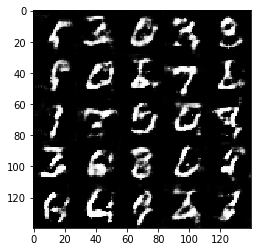

Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 1.8319
Epoch 1/2... Discriminator Loss: 0.8995... Generator Loss: 1.1993
Epoch 1/2... Discriminator Loss: 0.8274... Generator Loss: 1.5338
Epoch 1/2... Discriminator Loss: 0.8086... Generator Loss: 1.4727
Epoch 1/2... Discriminator Loss: 0.7348... Generator Loss: 1.9574
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 1.7614
Epoch 1/2... Discriminator Loss: 0.9359... Generator Loss: 1.1024
Epoch 1/2... Discriminator Loss: 0.8861... Generator Loss: 1.4515
Epoch 1/2... Discriminator Loss: 0.8079... Generator Loss: 1.9269
Epoch 1/2... Discriminator Loss: 0.8122... Generator Loss: 2.1395


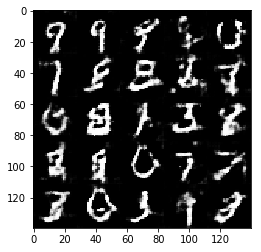

Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 1.3605
Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 1.1593
Epoch 1/2... Discriminator Loss: 0.8599... Generator Loss: 1.9808
Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 0.7800
Epoch 1/2... Discriminator Loss: 0.9081... Generator Loss: 2.3812
Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 3.0587
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 2.1995
Epoch 1/2... Discriminator Loss: 0.8903... Generator Loss: 2.2505
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 0.9119
Epoch 1/2... Discriminator Loss: 0.9830... Generator Loss: 1.0547


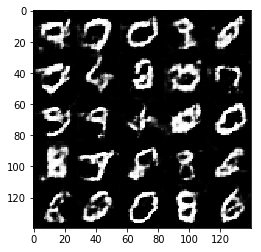

Epoch 1/2... Discriminator Loss: 0.9505... Generator Loss: 1.2071
Epoch 1/2... Discriminator Loss: 0.8206... Generator Loss: 1.4797
Epoch 1/2... Discriminator Loss: 1.2088... Generator Loss: 2.3490
Epoch 1/2... Discriminator Loss: 0.9302... Generator Loss: 1.3357
Epoch 1/2... Discriminator Loss: 0.8595... Generator Loss: 1.3429
Epoch 1/2... Discriminator Loss: 1.0407... Generator Loss: 0.9155
Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 1.1470
Epoch 1/2... Discriminator Loss: 0.8634... Generator Loss: 1.2972
Epoch 1/2... Discriminator Loss: 1.2414... Generator Loss: 2.7191


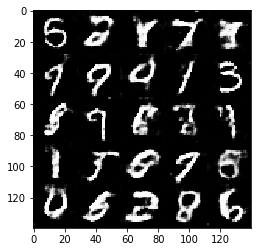

Epoch 1/2... Discriminator Loss: 0.9320... Generator Loss: 1.3436
Epoch 1/2... Discriminator Loss: 0.8096... Generator Loss: 1.5387
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 0.8505
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 1.7024
Epoch 2/2... Discriminator Loss: 1.5176... Generator Loss: 0.5089
Epoch 2/2... Discriminator Loss: 1.0617... Generator Loss: 2.4220
Epoch 2/2... Discriminator Loss: 0.9692... Generator Loss: 0.9203
Epoch 2/2... Discriminator Loss: 0.9437... Generator Loss: 1.0356
Epoch 2/2... Discriminator Loss: 1.0562... Generator Loss: 1.4403
Epoch 2/2... Discriminator Loss: 1.6254... Generator Loss: 2.9067


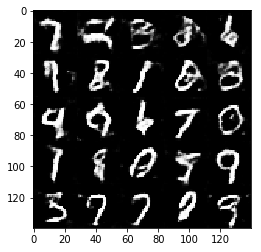

Epoch 2/2... Discriminator Loss: 1.1545... Generator Loss: 0.7463
Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 1.4697
Epoch 2/2... Discriminator Loss: 1.1217... Generator Loss: 0.7990
Epoch 2/2... Discriminator Loss: 1.0829... Generator Loss: 0.8381
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.7110
Epoch 2/2... Discriminator Loss: 0.8661... Generator Loss: 1.1900
Epoch 2/2... Discriminator Loss: 1.4913... Generator Loss: 0.5093
Epoch 2/2... Discriminator Loss: 0.8474... Generator Loss: 1.2588
Epoch 2/2... Discriminator Loss: 1.5383... Generator Loss: 0.4877
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 1.7808


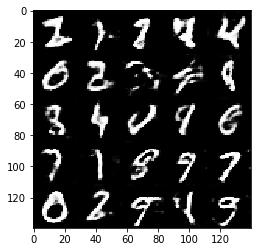

Epoch 2/2... Discriminator Loss: 0.8956... Generator Loss: 1.7268
Epoch 2/2... Discriminator Loss: 0.9906... Generator Loss: 0.9013
Epoch 2/2... Discriminator Loss: 1.0969... Generator Loss: 0.9132
Epoch 2/2... Discriminator Loss: 0.9362... Generator Loss: 1.2638
Epoch 2/2... Discriminator Loss: 1.1101... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 0.8386... Generator Loss: 1.7477
Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 1.2881
Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 1.5086
Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 1.1972
Epoch 2/2... Discriminator Loss: 2.1010... Generator Loss: 4.0355


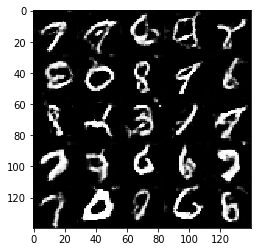

Epoch 2/2... Discriminator Loss: 1.2037... Generator Loss: 1.4372
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 0.7014
Epoch 2/2... Discriminator Loss: 1.0587... Generator Loss: 1.5707
Epoch 2/2... Discriminator Loss: 0.9232... Generator Loss: 1.0127
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.6110
Epoch 2/2... Discriminator Loss: 0.8252... Generator Loss: 1.7437
Epoch 2/2... Discriminator Loss: 0.8140... Generator Loss: 1.1742
Epoch 2/2... Discriminator Loss: 0.7485... Generator Loss: 2.1860
Epoch 2/2... Discriminator Loss: 1.7479... Generator Loss: 0.4690
Epoch 2/2... Discriminator Loss: 1.2796... Generator Loss: 0.6357


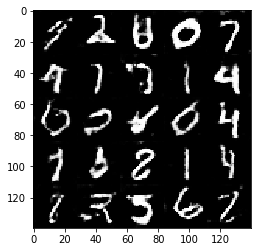

Epoch 2/2... Discriminator Loss: 1.1558... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 1.5984
Epoch 2/2... Discriminator Loss: 1.4112... Generator Loss: 2.3852
Epoch 2/2... Discriminator Loss: 1.1844... Generator Loss: 2.4198
Epoch 2/2... Discriminator Loss: 0.9580... Generator Loss: 1.0414
Epoch 2/2... Discriminator Loss: 1.1357... Generator Loss: 0.7215
Epoch 2/2... Discriminator Loss: 2.1055... Generator Loss: 0.2816
Epoch 2/2... Discriminator Loss: 0.9931... Generator Loss: 0.9899
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 1.0604
Epoch 2/2... Discriminator Loss: 1.4849... Generator Loss: 0.4684


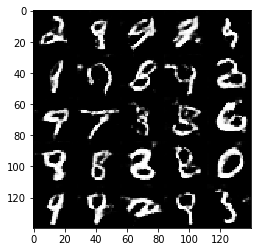

Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 2.7126
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.6677
Epoch 2/2... Discriminator Loss: 0.9703... Generator Loss: 1.2113
Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 0.7570
Epoch 2/2... Discriminator Loss: 1.2401... Generator Loss: 2.1385
Epoch 2/2... Discriminator Loss: 0.9188... Generator Loss: 0.9830
Epoch 2/2... Discriminator Loss: 1.4993... Generator Loss: 2.9766
Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 0.7871
Epoch 2/2... Discriminator Loss: 1.1122... Generator Loss: 2.1149
Epoch 2/2... Discriminator Loss: 0.9825... Generator Loss: 0.9995


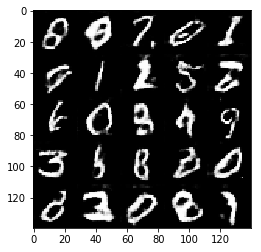

Epoch 2/2... Discriminator Loss: 1.1832... Generator Loss: 0.6505
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 1.0512
Epoch 2/2... Discriminator Loss: 1.0611... Generator Loss: 0.9715
Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 0.9014
Epoch 2/2... Discriminator Loss: 0.8501... Generator Loss: 1.3718
Epoch 2/2... Discriminator Loss: 1.8421... Generator Loss: 0.3484
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 1.6150
Epoch 2/2... Discriminator Loss: 0.8104... Generator Loss: 1.7145
Epoch 2/2... Discriminator Loss: 1.0460... Generator Loss: 0.8970
Epoch 2/2... Discriminator Loss: 0.9219... Generator Loss: 0.9638


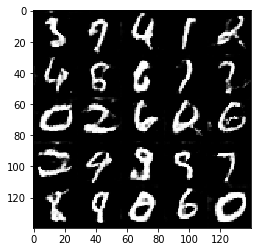

Epoch 2/2... Discriminator Loss: 1.8871... Generator Loss: 0.4152
Epoch 2/2... Discriminator Loss: 1.4866... Generator Loss: 2.6854
Epoch 2/2... Discriminator Loss: 0.8414... Generator Loss: 1.4036
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 1.9475
Epoch 2/2... Discriminator Loss: 0.9755... Generator Loss: 0.9369
Epoch 2/2... Discriminator Loss: 0.8834... Generator Loss: 1.1598
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.9269
Epoch 2/2... Discriminator Loss: 0.8132... Generator Loss: 1.1751
Epoch 2/2... Discriminator Loss: 1.4237... Generator Loss: 0.5496
Epoch 2/2... Discriminator Loss: 0.9634... Generator Loss: 1.1185


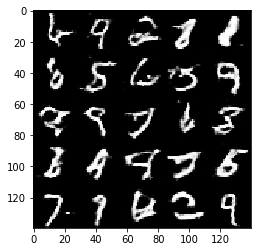

Epoch 2/2... Discriminator Loss: 0.8789... Generator Loss: 1.1815
Epoch 2/2... Discriminator Loss: 0.9740... Generator Loss: 2.2717
Epoch 2/2... Discriminator Loss: 1.0174... Generator Loss: 0.8636
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 1.3039
Epoch 2/2... Discriminator Loss: 0.9257... Generator Loss: 1.0665
Epoch 2/2... Discriminator Loss: 0.9447... Generator Loss: 1.8327
Epoch 2/2... Discriminator Loss: 1.2587... Generator Loss: 0.6180
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 0.9646
Epoch 2/2... Discriminator Loss: 1.9677... Generator Loss: 0.2998
Epoch 2/2... Discriminator Loss: 0.7962... Generator Loss: 1.8401


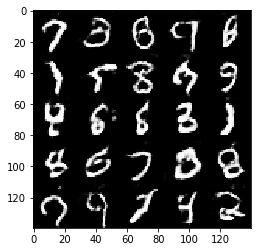

Epoch 2/2... Discriminator Loss: 0.8908... Generator Loss: 1.1625
Epoch 2/2... Discriminator Loss: 1.2663... Generator Loss: 0.6139
Epoch 2/2... Discriminator Loss: 0.8110... Generator Loss: 2.4605
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 1.6112
Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 1.5213
Epoch 2/2... Discriminator Loss: 1.6647... Generator Loss: 0.5149
Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 0.8275


In [12]:
batch_size = 64
z_dim = 100
learning_rate = .0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
100
28 28 3 100
Epoch 1/1... Discriminator Loss: 0.7679... Generator Loss: 5.1105
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 3.8800
Epoch 1/1... Discriminator Loss: 1.8078... Generator Loss: 13.9859
Epoch 1/1... Discriminator Loss: 3.0726... Generator Loss: 0.1421
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 2.3276
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 2.8218
Epoch 1/1... Discriminator Loss: 2.1346... Generator Loss: 0.2398
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 3.1221
Epoch 1/1... Discriminator Loss: 0.7378... Generator Loss: 1.3751


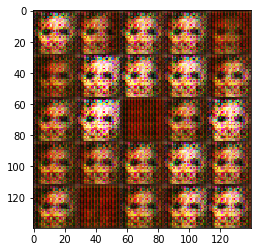

Epoch 1/1... Discriminator Loss: 0.4399... Generator Loss: 3.8109
Epoch 1/1... Discriminator Loss: 0.5601... Generator Loss: 4.9658
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 0.6903... Generator Loss: 2.0529
Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 3.8745
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 0.6223... Generator Loss: 3.6731
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 3.7635
Epoch 1/1... Discriminator Loss: 1.9861... Generator Loss: 3.8217
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 1.4047


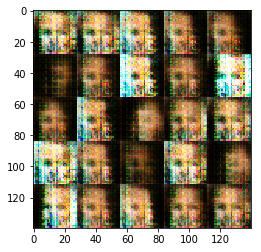

Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 1.1992
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 2.0279
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 1.7035
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 1.0349


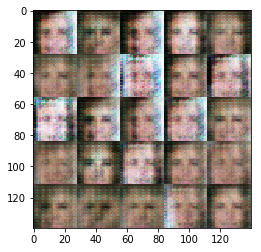

Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 1.3997
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.2073
Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 1.3759
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 0.9566


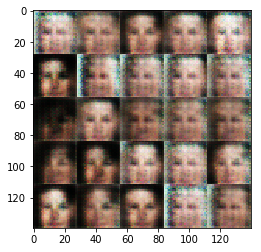

Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 1.6845... Generator Loss: 1.3681
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 1.5114
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 1.3371
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.2726
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.9310


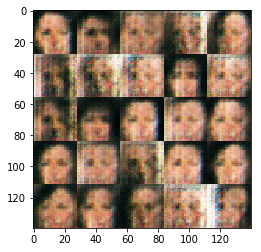

Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 1.1081
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.0851
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 2.2382
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.3674
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 1.4229
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 1.1217


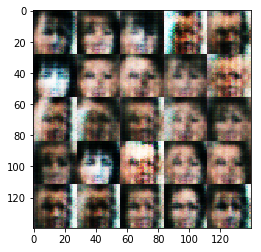

Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.9000
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 1.4589
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 1.0642
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 1.4218
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.1062


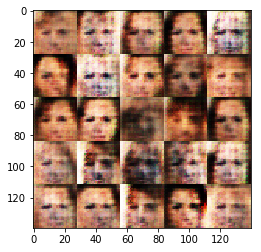

Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.2665
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.3428
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 1.4800
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 1.4356
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 1.8928
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 1.7125
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 2.0769... Generator Loss: 0.2835


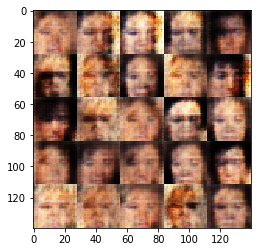

Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 2.1222
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 1.8673
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 1.9514
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.4513
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.9541


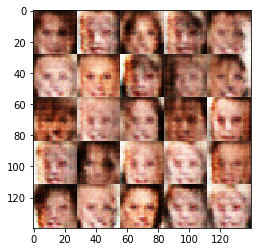

Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.6048
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.5324
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 1.5522
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.2324
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.7995
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.8986


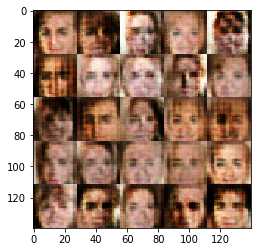

Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 1.3259
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 2.2546
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 1.1720
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 1.0989


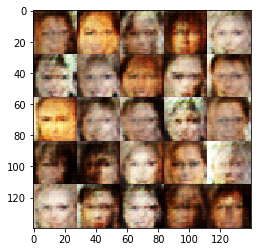

Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.4464
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 1.6573
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.1217
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.0356


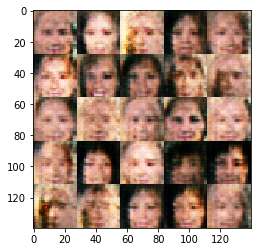

Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 2.2318
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.5029


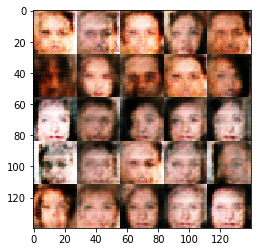

Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 1.2531
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.6413
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 2.0222
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 1.3021
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.8525


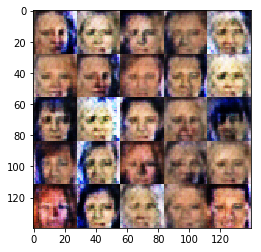

Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.2137
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.3792
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.3886
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 1.8190
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.1229


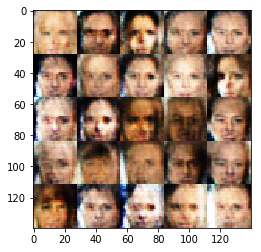

Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 1.9920
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.5177
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 1.9009
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 1.5300
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 0.4614


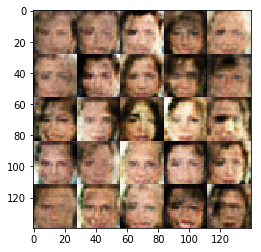

Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 1.0112
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 1.3091
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 0.9820
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 1.6958


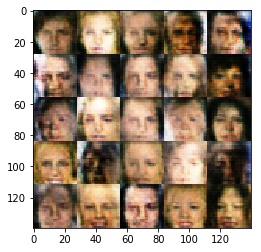

Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 2.2472
Epoch 1/1... Discriminator Loss: 1.6532... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.1896
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 1.6561
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.6158


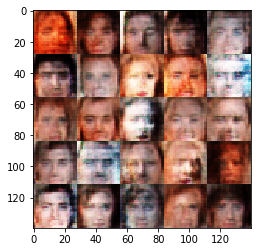

Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.7238
Epoch 1/1... Discriminator Loss: 1.7952... Generator Loss: 0.3194
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.1643
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 1.8062
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.8300
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 1.7116
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.6250


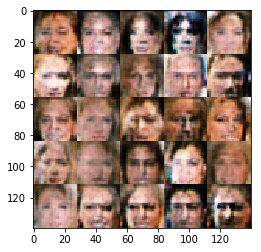

Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 1.2366
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 1.3443
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 2.3219
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 1.4395


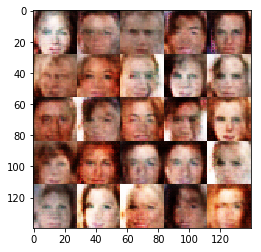

Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 1.3029
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.2712
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.6615
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 2.0400
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.1542


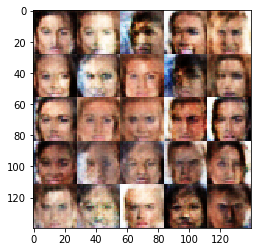

Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.4366
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 1.2885
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.1414


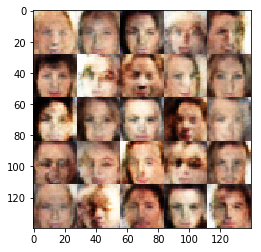

Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 0.8434... Generator Loss: 1.3123
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 1.6572
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.4805
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.6921
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.9901


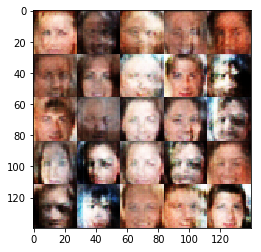

Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 0.9502
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.9498
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.0280
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.7341


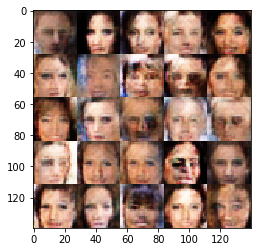

Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 1.1249
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 1.2304
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 1.2850
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.9920


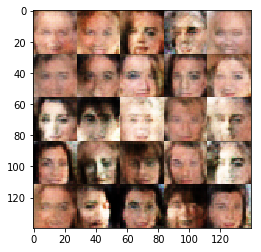

Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 2.1132
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 1.4340
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 1.3959


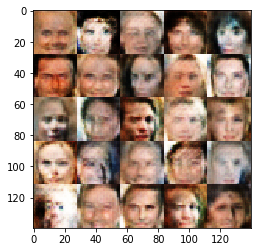

Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.4116
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.9212
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 1.3360
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.8325


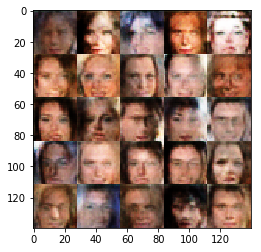

Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.6017
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.3875
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.8408
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.4064
Epoch 1/1... Discriminator Loss: 1.5701... Generator Loss: 0.4182
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 1.0071


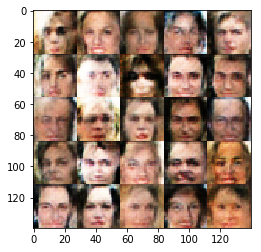

Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.5390
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 1.8899
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 1.1697
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 1.5825
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 1.2616
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 0.8478


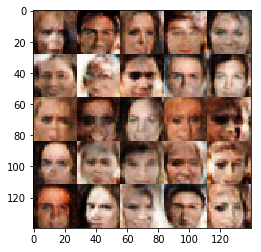

Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.3147
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 1.5424
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 1.4613
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.6981


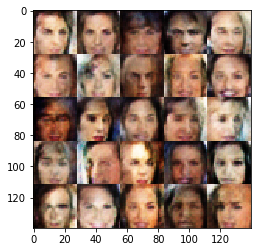

Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.2607
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 1.1557
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 1.1493
Epoch 1/1... Discriminator Loss: 1.6560... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 1.2008


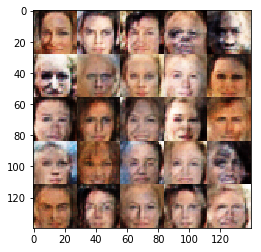

Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 2.4280
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 1.4054
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 1.6821


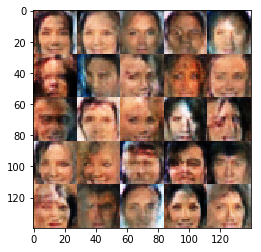

Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.6486
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.5631
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.3210
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.5567


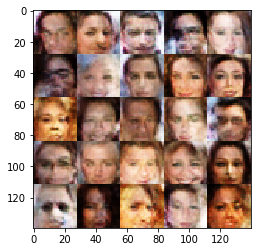

Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 1.3045
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 1.2714
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.5984
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 1.8353
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.4232
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.1169


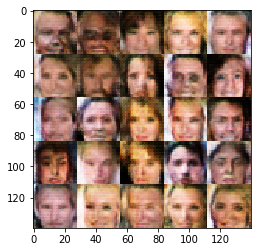

Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.5030
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.9773
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.6530
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 1.1655
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.5348


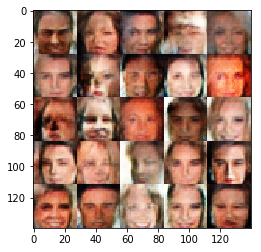

Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 1.1588
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 1.2610
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.6220


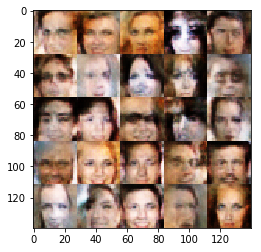

Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.3621
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 1.4599
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 1.0908


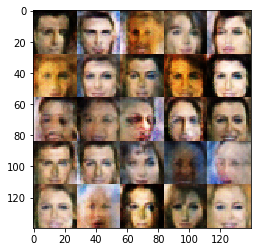

Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 1.3064
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 1.2421
Epoch 1/1... Discriminator Loss: 1.7355... Generator Loss: 0.3499
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 1.2750
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 1.0526


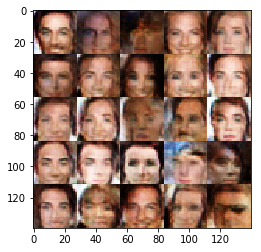

Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 1.2534
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.6137
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.3438


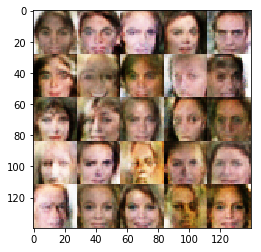

Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.2358
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 1.7991
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.8390


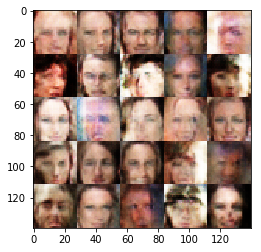

Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.3366
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 1.8536
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 1.3309
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.6614


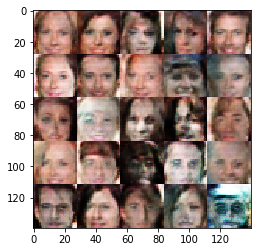

Epoch 1/1... Discriminator Loss: 1.7674... Generator Loss: 0.3009
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 1.3162
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 1.0429
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 1.2215
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.4476
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.9468


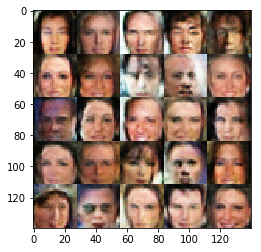

Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.1333
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.4679
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.9933


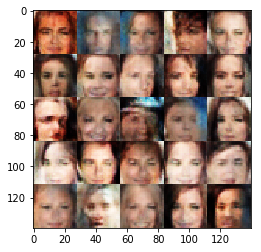

Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.2266
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.1844
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.0644
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.8694
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.7341


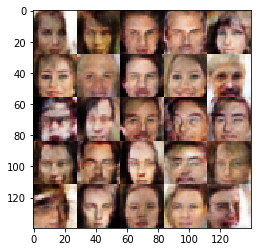

Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.4733
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 0.3947
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 1.1647
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.5670
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.2786
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.5092


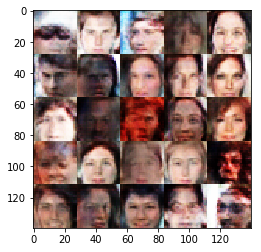

Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.5174
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.9897


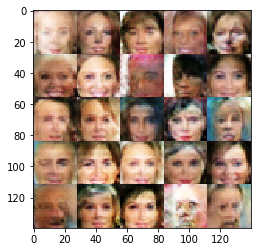

Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.7323
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.4025
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 1.1780
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.3195
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.5633


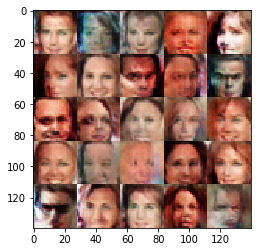

Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 1.0561
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.6540... Generator Loss: 0.3842
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 1.1211
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 1.6063
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.2398


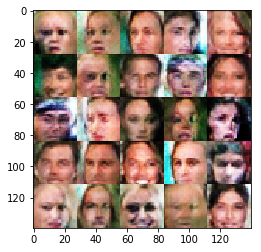

Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.5785
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 1.0883


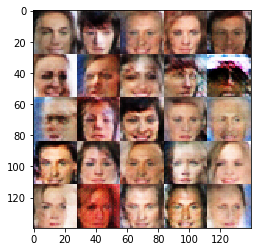

Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 1.0731


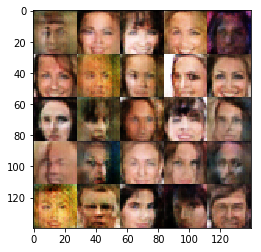

Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 1.6440
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 1.2775
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.9544


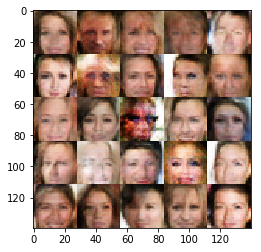

Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 1.3732
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 1.3830
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.2860
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 1.2494


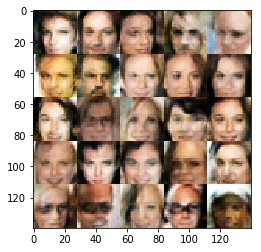

Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.4931
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.7503


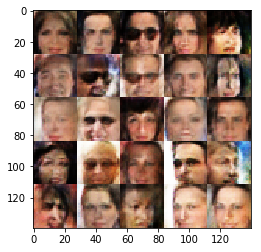

Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 1.2458
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 1.2774
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.6553


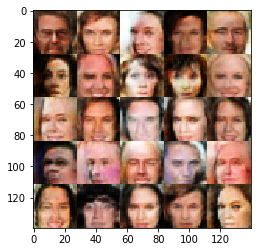

Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.5619
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.5529
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 1.2514
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.4742


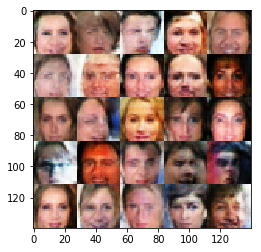

Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.5512... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.8355


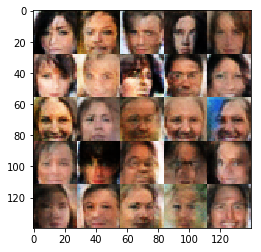

Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.2421
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.1467
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.2835


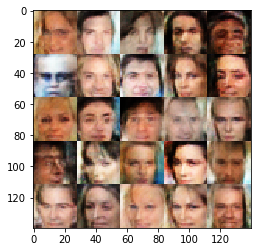

Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.7677


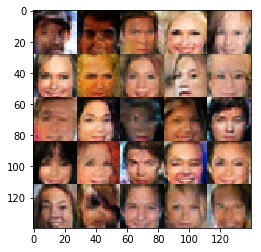

Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 1.3832
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.5912... Generator Loss: 0.3691
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.8295


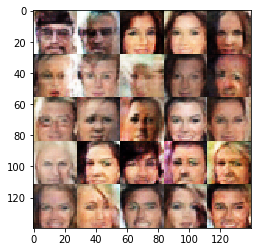

Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 1.0880
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 1.1590
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.1986


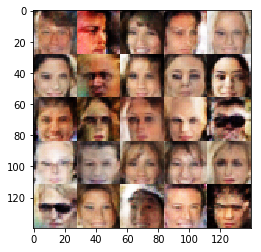

Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 1.0354
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.5333
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.9400


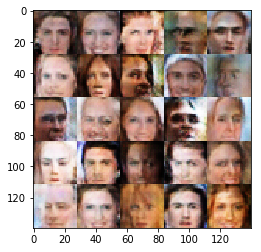

Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.1521
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.6663


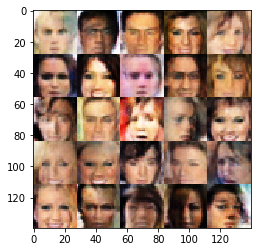

Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.3121
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.5455
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 1.2369
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.1912
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.6181


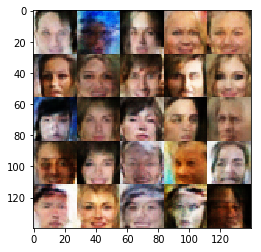

Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.0354
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.0474


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.